In [1]:
import plot
import importlib
import numpy as np
import random
import os
import glob
import h5py
import math
import scipy
import random
import classify
import warnings
import preprocess
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from os import path
from scipy import stats
from scipy.io import loadmat
from matplotlib import gridspec
from numpy.linalg import norm
from scipy.spatial import distance
from sklearn import decomposition
from matplotlib.colors import LinearSegmentedColormap
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
warnings.filterwarnings('ignore')
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

np.random.seed(42)
random.seed(42)


In [2]:
# reload when updating code
importlib.reload(preprocess)
# mouse and date

mice = ['NN11'] 
dates_per_mouse = {'NN11': ['210626']}

for mouse in mice:
    dates = dates_per_mouse[mouse]  # Get the list of dates for the current mouse
    days = len(dates)  # Correct number of days for this mouse
    
    for day_idx, date in enumerate(dates):
        print(mouse, date)
        
        # Create folders to save files
        paths = preprocess.create_folders(mouse, date)
        print('folders created')
        
        # Import data for mouse and date as dict
        session_data = preprocess.load_data(paths)
        print('data loaded')
        
        # Process and plot behavior
        behavior = preprocess.process_behavior(session_data, paths)
        print('behavior done')
        
        # Save masks so can run in Matlab to process other planes
        # preprocess.cell_masks(paths, 0)
        print('masks saved')
        
        # Grab activity
        deconvolved = preprocess.process_activity(paths, 'spks', 3, 0)
        print('activity processed')
        
        # Normalize activity
        norm_deconvolved = preprocess.normalize_deconvolved(deconvolved, behavior, paths, 0)
        print('activity normalized')
        
        # Gaussian filter activity
        norm_moving_deconvolved_filtered = preprocess.difference_gaussian_filter(norm_deconvolved, 4, behavior, paths, 0)
        print('activity filtered')
        
        # Make trial-averaged traces and baseline subtract
        mean_cs_1_responses_df = preprocess.normalized_trial_averaged(norm_deconvolved, behavior, 'cs_1')
        mean_cs_2_responses_df = preprocess.normalized_trial_averaged(norm_deconvolved, behavior, 'cs_2')
        print('traces done')
        
        # Get significant cells
        [cs_1_poscells, cs_1_negcells] = preprocess.sig_test(norm_deconvolved, behavior, 'cs_1')
        [cs_2_poscells, cs_2_negcells] = preprocess.sig_test(norm_deconvolved, behavior, 'cs_2')
        [both_poscells, both_sigcells] = preprocess.combine_sig(cs_1_poscells, cs_1_negcells, cs_2_poscells, cs_2_negcells)
        print('sig cells done')
        
        # Get index of top cell differences
        idx = preprocess.get_index(behavior, mean_cs_1_responses_df, mean_cs_2_responses_df, cs_1_poscells, cs_2_poscells, both_poscells, both_sigcells, paths, 1)
        print('idx done')
        
        # Get prior for synchronous cue activity
        prior = classify.prior(norm_moving_deconvolved_filtered, idx['cs_1'], idx['cs_2'], behavior, [])
        print('prior done')
        
        # Logistic regression
        #y_pred, feature_importance_all = classify.log_regression_no_splits(behavior, norm_deconvolved, norm_moving_deconvolved_filtered, both_poscells, prior)
        y_pred_log, feature_importance_all = classify.log_regression_splits(behavior, norm_deconvolved, norm_moving_deconvolved_filtered, both_poscells, prior)

        print('logistic regression done')
        
        # Process classified output
        y_pred = classify.process_classified(y_pred_log, prior, paths, 1)
        print('classified done')
    


NN11 210626
folders created
data loaded
behavior done
masks saved
activity processed
activity normalized
activity filtered
traces done
sig cells done
idx done
prior done
logistic regression done
classified done


In [3]:
activity = norm_deconvolved.to_numpy()
activity = activity[idx['both'].index]

# Commented out code for filtering significant reactivated cells.
# sig_cells = preprocess.sig_reactivated_cells([], [], [], [], [], paths, 0)
# activity = activity[sig_cells > 0, :]

# Initialize lists to store mean activities and onsets for two different cues.
mean_activity_cs_1 = []
mean_activity_cs_2 = []
mean_activity_cs_any = []
onsets_cs_1 = []
onsets_cs_2 = []

# Loop over each onset and offset in behavior data.
for i in range(0, len(behavior['onsets'])):
    # Calculate the mean activity for the given onset to offset period.
    temp_activity = np.mean(activity[:, int(behavior['onsets'][i]):int(behavior['offsets'][i]) + 1], axis=1)
    # Check if the cue code matches cs_1_code, and store the mean activity and onset.
    if behavior['cue_codes'][i] == behavior['cs_1_code']:
        mean_activity_cs_1.append(temp_activity)
        onsets_cs_1.append(behavior['onsets'][i])
        mean_activity_cs_any.append(temp_activity)
    # Check if the cue code matches cs_2_code, and store the mean activity and onset.
    if behavior['cue_codes'][i] == behavior['cs_2_code']:
        mean_activity_cs_2.append(temp_activity)
        onsets_cs_2.append(behavior['onsets'][i])
        mean_activity_cs_any.append(temp_activity)

cos_sim = lambda a, b: np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))
topn = 0.05

# Commented out code for filtering significant reactivated cells.
# sig_cells = preprocess.sig_reactivated_cells([], [], [], [], [], paths, 0)
# activity = activity[sig_cells > 0, :]

# Initialize lists to store mean activities and onsets for two different cues.
mean_activity_cs_1 = []
mean_activity_cs_2 = []
mean_activity_cs_any = []
onsets_cs_1 = []
onsets_cs_2 = []

# Loop over each onset and offset in behavior data.
for i in range(0, len(behavior['onsets'])):
    # Calculate the mean activity for the given onset to offset period.
    temp_activity = np.mean(activity[:, int(behavior['onsets'][i]):int(behavior['offsets'][i]) + 1], axis=1)
    # Check if the cue code matches cs_1_code, and store the mean activity and onset.
    if behavior['cue_codes'][i] == behavior['cs_1_code']:
        mean_activity_cs_1.append(temp_activity)
        onsets_cs_1.append(behavior['onsets'][i])
        mean_activity_cs_any.append(temp_activity)
    # Check if the cue code matches cs_2_code, and store the mean activity and onset.
    if behavior['cue_codes'][i] == behavior['cs_2_code']:
        mean_activity_cs_2.append(temp_activity)
        onsets_cs_2.append(behavior['onsets'][i])
        mean_activity_cs_any.append(temp_activity)

# Normalize the mean activities for each trial.
mean_activity_cs_1 = mean_activity_cs_1 / np.mean(mean_activity_cs_any, axis=0)
mean_activity_cs_2 = mean_activity_cs_2 / np.mean(mean_activity_cs_any, axis=0)

mean_activity_cs_1 = np.stack(mean_activity_cs_1, axis=0)
mean_activity_cs_2 = np.stack(mean_activity_cs_2, axis=0)

# Calculate the mean of the first and last three mean activities for cs_1 and cs_2.
n_centroids = 3
mean_activity_cs_1_mean = [np.mean(mean_activity_cs_1[0:n_centroids], axis=0), np.mean(mean_activity_cs_1[len(mean_activity_cs_1) - n_centroids:len(mean_activity_cs_1)], axis=0)]
mean_activity_cs_2_mean = [np.mean(mean_activity_cs_2[0:n_centroids], axis=0), np.mean(mean_activity_cs_2[len(mean_activity_cs_2) - n_centroids:len(mean_activity_cs_2)], axis=0)]

# Calculate the difference vectors between the early and late mean activities for cs_1 and cs_2.
mean_activity_cs_1_vec = mean_activity_cs_1_mean[1] - mean_activity_cs_1_mean[0]
mean_activity_cs_2_vec = mean_activity_cs_2_mean[1] - mean_activity_cs_2_mean[0]

late_trails_1 = mean_activity_cs_1_mean[1]
top_n_percent_indices_1 = np.argsort(late_trails_1)[-int(len(late_trails_1) * topn):]
mean_activity_cstopn_1 = mean_activity_cs_1[:, top_n_percent_indices_1]
mean_activity_cstopn_1_late = mean_activity_cs_1_mean[1][top_n_percent_indices_1]

late_trails_2 = mean_activity_cs_2_mean[1]
top_n_percent_indices_2 = np.argsort(late_trails_2)[-int(len(late_trails_2) * topn):]
mean_activity_cstopn_2 = mean_activity_cs_2[:, top_n_percent_indices_2]
mean_activity_cstopn_2_late = mean_activity_cs_2_mean[1][top_n_percent_indices_2]

sim_cs_1 = np.zeros(len(mean_activity_cs_1))
sim_cs_2 = np.zeros(len(mean_activity_cs_2))

# Normalize the mean activities for each trial using the difference vectors.
for i in range(0, len(mean_activity_cs_1)):
    sim_cs_1[i] = cos_sim(mean_activity_cstopn_1[i], mean_activity_cstopn_1_late)
    # sim_cs_1[i] = cos_sim(mean_activity_cs_1[i], mean_activity_cs_1_mean[1])
    # sim_cs_1[i] = np.dot(mean_activity_cs_1[i], mean_activity_cs_1_vec) / np.linalg.norm(mean_activity_cs_1_vec)
for i in range(0, len(mean_activity_cs_2)):
    sim_cs_2[i] = cos_sim(mean_activity_cstopn_2[i], mean_activity_cstopn_2_late)
    # sim_cs_2[i] = cos_sim(mean_activity_cs_2[i], mean_activity_cs_2_mean[1])
    # sim_cs_2[i] = np.dot(mean_activity_cs_2[i], mean_activity_cs_2_vec) / np.linalg.norm(mean_activity_cs_2_vec)


# Initialize lists to store mean activities and trial indices for reactivation events.
mean_activity_r_1 = []
mean_activity_r_2 = []
mean_activity_r_any = []
trial_r_1 = []
trial_r_2 = []

# Copy reactivation predictions for cs_1 and cs_2.
reactivation_cs_1 = y_pred[:, 0].copy()
reactivation_cs_2 = y_pred[:, 1].copy()

# Set a threshold for reactivation probability.
p_threshold = .75

# Initialize variables for reactivation event detection.
cs_1_peak = 0
cs_2_peak = 0
i = 0
next_r = 0

# Loop through reactivation predictions to detect reactivation events.
while i < len(reactivation_cs_1) - 1:
    # Check if there is a reactivation event.
    if reactivation_cs_1[i] > 0 or reactivation_cs_2[i] > 0:
        if next_r == 0:
            r_start = i
            next_r = 1
        # Update peak reactivation values.
        if reactivation_cs_1[i] > cs_1_peak:
            cs_1_peak = reactivation_cs_1[i]
        if reactivation_cs_2[i] > cs_2_peak:
            cs_2_peak = reactivation_cs_2[i]
        #print(reactivation_cs_1[i + 1], reactivation_cs_2[i + 1])
        # Check if the reactivation event has ended.
        if reactivation_cs_1[i + 1] <= 0.001 and reactivation_cs_2[i + 1]<= 0.001:
            r_end = i + 1
            next_r = 0
            # Store mean activity and trial index for cs_1 reactivation events above the threshold.
            if cs_1_peak > p_threshold:
                for j in range(0, len(onsets_cs_1)):
                    if r_start < onsets_cs_1[j] and r_start > onsets_cs_1[j-1] and r_start < onsets_cs_1[j-1] + int(behavior['framerate']*61):
                        mean_activity_r_1.append(np.mean(activity[:, r_start:r_end], axis=1))
                        trial_r_1.append(j-1)
                        mean_activity_r_any.append(np.mean(activity[:, r_start:r_end], axis=1))
                        break
            # Store mean activity and trial index for cs_2 reactivation events above the threshold.
            if cs_2_peak > p_threshold:
                for j in range(0, len(onsets_cs_2)):
                    if r_start < onsets_cs_2[j] and r_start > onsets_cs_2[j-1] and r_start < onsets_cs_2[j-1] + int(behavior['framerate']*61):
                        mean_activity_r_2.append(np.mean(activity[:, r_start:r_end], axis=1))
                        trial_r_2.append(j-1)
                        mean_activity_r_any.append(np.mean(activity[:, r_start:r_end], axis=1))
                        break
            # Reset variables for the next reactivation event.
            i = r_end
            cs_1_peak = 0
            cs_2_peak = 0
    i += 1


# Normalize the reactivation mean activities.
mean_activity_r_1 = mean_activity_r_1 / np.mean(mean_activity_r_any, axis=0)
mean_activity_r_2 = mean_activity_r_2 / np.mean(mean_activity_r_any, axis=0)

mean_activity_r_1 = np.stack(mean_activity_r_1, axis=0)
mean_activity_r_2 = np.stack(mean_activity_r_2, axis=0)

# mean_activity_rtopn_1 = mean_activity_r_1[:, top_n_percent_indices_1]
# mean_activity_cstopn_1_late = mean_activity_cs_1_mean[1][top_n_percent_indices_1]

# mean_activity_rtopn_2 = mean_activity_r_2[:, top_n_percent_indices_2]
# mean_activity_cstopn_2_late = mean_activity_cs_2_mean[1][top_n_percent_indices_2]

sim_r_1 = np.zeros(len(mean_activity_r_1))
sim_r_2 = np.zeros(len(mean_activity_r_2))

sim_r_1_random = np.zeros(len(mean_activity_r_1))

zero_indices = np.where(mean_activity_r_1 != 0)
    
# Normalize the reactivation mean activities using the difference vectors.
for i in range(0, len(mean_activity_r_1)):
    # nonzero_indices = np.where(mean_activity_r_1[i] != 0)
    top_n_percent_indices_r_1 = np.argsort(mean_activity_r_1[i])[-int(len(mean_activity_r_1[i]) * topn):]
    sim_r_1[i] = cos_sim(mean_activity_r_1[i][np.intersect1d(top_n_percent_indices_r_1, top_n_percent_indices_1)], mean_activity_cs_1_mean[1][np.intersect1d(top_n_percent_indices_r_1, top_n_percent_indices_1)])
    
    chosen_indices = np.random.randint(0, len(mean_activity_r_1[i]), 27)
    sim_r_1_random[i] = cos_sim(mean_activity_r_1[i][chosen_indices], mean_activity_cs_1_mean[1][chosen_indices])
    # sim_r_1[i] = cos_sim(mean_activity_rtopn_1[i], mean_activity_cstopn_1_late)
    # sim_r_1[i] = cos_sim(mean_activity_r_1[i], mean_activity_cs_1_mean[1])
    # sim_r_1[i] = np.dot(mean_activity_r_1[i], mean_activity_cs_1_vec) / np.linalg.norm(mean_activity_cs_1_vec)
for i in range(0, len(mean_activity_r_2)):
    # nonzero_indices = np.where(mean_activity_r_2[i] != 0)
    top_n_percent_indices_r_2 = np.argsort(mean_activity_r_2[i])[-int(len(mean_activity_r_2[i]) * topn):]
    sim_r_2[i] = cos_sim(mean_activity_r_2[i][np.intersect1d(top_n_percent_indices_r_2, top_n_percent_indices_2)], mean_activity_cs_2_mean[1][np.intersect1d(top_n_percent_indices_r_2, top_n_percent_indices_2)])
    # sim_r_2[i] = cos_sim(mean_activity_rtopn_2[i], mean_activity_cstopn_2_late)
    # sim_r_2[i] = cos_sim(mean_activity_r_2[i], mean_activity_cs_2_mean[1])
    # sim_r_2[i] = np.dot(mean_activity_r_2[i], mean_activity_cs_2_vec) / np.linalg.norm(mean_activity_cs_2_vec)


In [5]:
SERs = np.concatenate([mean_activity_cs_1, mean_activity_cs_2])
Reacts = np.concatenate([mean_activity_r_1, mean_activity_r_2])

def center_data(data):
    """
    Centers the data by subtracting the mean activity per neuron.

    Parameters:
    - data: 2D numpy array (trials/reactivations, neurons)

    Returns:
    - centered_data: 2D numpy array with mean-centered values
    - neuron_means: 1D array of mean values per neuron
    """

    # Compute mean activity for each neuron across all trials/reactivations
    neuron_means = np.mean(data, axis=0)  # Shape: (neurons,)

    # Subtract mean from each neuron's activity
    centered_data = data - neuron_means

    return centered_data, neuron_means


# Center the reactivation and SER data
reacts_centered, r_means = center_data(Reacts)
SER_centered, cs_means = center_data(SERs)

print("Reactivation data centered shape:", reacts_centered.shape)
print("SER data centered shape:", SER_centered.shape)

# Check if means are close to zero (should be near zero after centering)
print("Mean of centered reactivation data:", np.mean(reacts_centered, axis=0))
print("Mean of centered SER data:", np.mean(SER_centered, axis=0))




Reactivation data centered shape: (250, 3124)
SER data centered shape: (128, 3124)
Mean of centered reactivation data: [-1.57651669e-16 -6.27498054e-16 -6.75459688e-16 ...  4.26325641e-17
 -4.50306459e-16 -9.76996262e-18]
Mean of centered SER data: [ 1.82145965e-16 -9.54097912e-17  5.32560107e-16 ... -4.17200996e-16
 -3.24393290e-16 -3.20056481e-16]


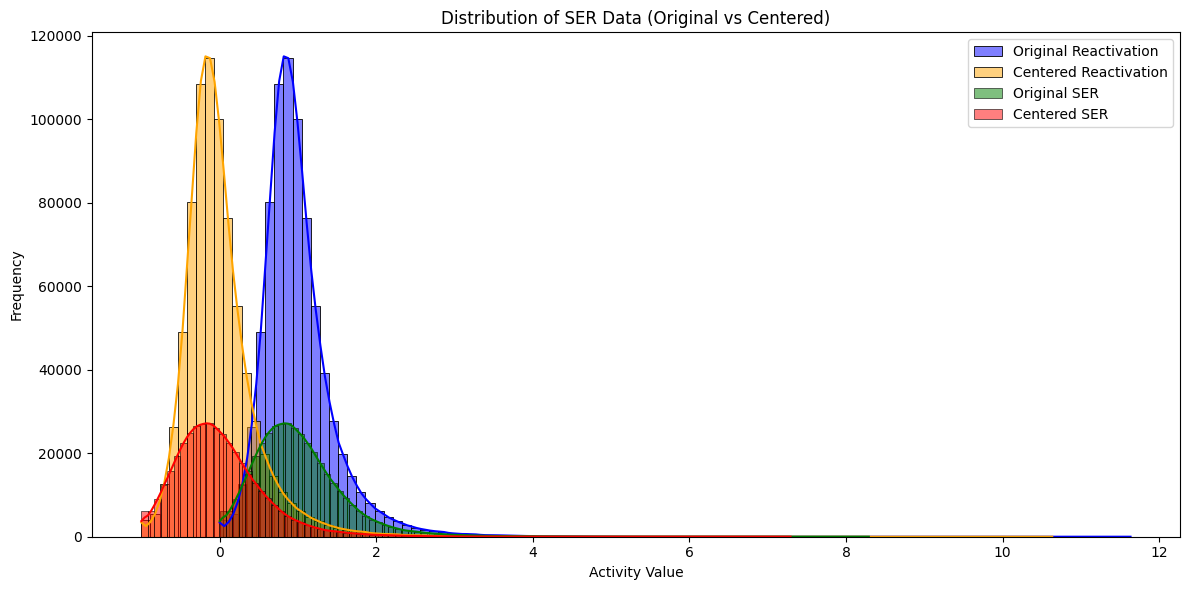

In [9]:
# Flatten the data for plotting
original_r_flat = Reacts.flatten()
centered_r_flat = reacts_centered.flatten()
original_cs_flat = SERs.flatten()
centered_cs_flat = SER_centered.flatten()

# Plot the distributions
plt.figure(figsize=(12, 6))

# Plot original vs centered reactivation data
sns.histplot(original_r_flat, bins=100, alpha=0.5, label='Original Reactivation', color='blue', kde=True)
sns.histplot(centered_r_flat, bins=100, alpha=0.5, label='Centered Reactivation', color='orange', kde=True)
plt.title("Distribution of Reactivation Data (Original vs Centered)")
plt.xlabel("Activity Value")
plt.ylabel("Frequency")
plt.legend()

# Plot original vs centered SER data
sns.histplot(original_cs_flat, bins=100, alpha=0.5, label='Original SER', color='green', kde=True)
sns.histplot(centered_cs_flat, bins=100, alpha=0.5, label='Centered SER', color='red', kde=True)
plt.title("Distribution of SER Data (Original vs Centered)")
plt.xlabel("Activity Value")
plt.ylabel("Frequency")
plt.legend()

plt.tight_layout()
plt.show()

PCA Analysis for Reactivation Data:


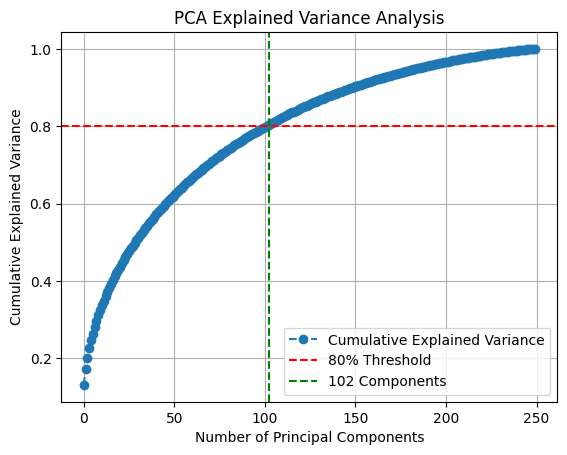

Number of components to explain 80% variance: 102

PCA Analysis for SER Data:


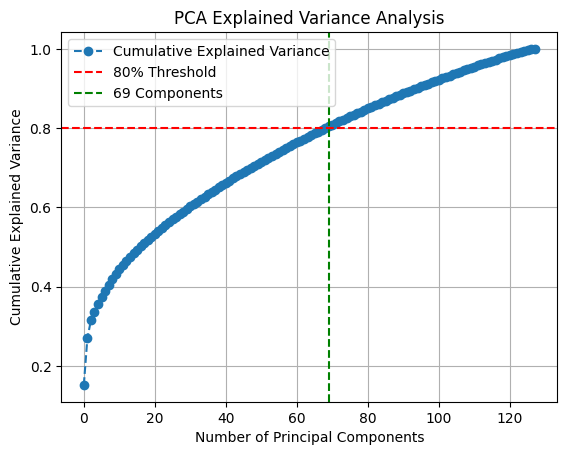

Number of components to explain 80% variance: 69
(250, 102) (128, 69)


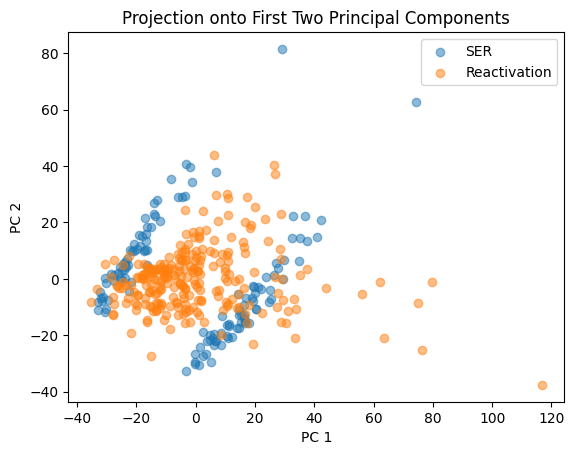

In [21]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Function to perform PCA and analyze explained variance
def perform_pca(data, explained_variance_threshold=0.80):
    """
    Performs PCA on the input data and determines the number of components 
    needed to explain the given variance threshold.

    Parameters:
    - data: 2D numpy array (samples, features)
    - explained_variance_threshold: float, target variance to explain (default = 0.80)

    Returns:
    - pca: trained PCA object
    - num_components: number of components required to reach threshold
    """

    # Standardize the data 
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data)

    # Fit PCA model
    pca = PCA()
    pca.fit(data_scaled)

    # Calculate cumulative explained variance
    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

    # Find the number of components needed to explain desired variance
    num_components = np.argmax(cumulative_variance >= explained_variance_threshold) + 1

    # Project data onto top k principal components
    projected_data = pca.transform(data_scaled)[:, :num_components]

    # Plot explained variance ratio
    plt.plot(cumulative_variance, marker='o', linestyle='--', label='Cumulative Explained Variance')
    plt.axhline(y=explained_variance_threshold, color='r', linestyle='--', label=f'{explained_variance_threshold * 100:.0f}% Threshold')
    plt.axvline(x=num_components, color='g', linestyle='--', label=f'{num_components} Components')
    plt.xlabel('Number of Principal Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.title('PCA Explained Variance Analysis')
    plt.legend()
    plt.grid()
    plt.show()

    print(f"Number of components to explain {explained_variance_threshold * 100:.0f}% variance: {num_components}")

    return pca, num_components, projected_data


# Perform PCA on reactivation data
print("PCA Analysis for Reactivation Data:")
pca_r, num_components_r, reactivation_projected = perform_pca(reacts_centered)

# Perform PCA on SER data
print("\nPCA Analysis for SER Data:")
pca_cs, num_components_cs, ser_projected = perform_pca(SER_centered)

print(reactivation_projected.shape, ser_projected.shape)

plt.scatter(ser_projected[:, 0], ser_projected[:, 1], alpha=0.5, label="SER")
plt.scatter(reactivation_projected[:, 0], reactivation_projected[:, 1], alpha=0.5, label="Reactivation")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.legend()
plt.title("Projection onto First Two Principal Components")
plt.show()


(139, 3124)
PCA Analysis for Reactivation Data:


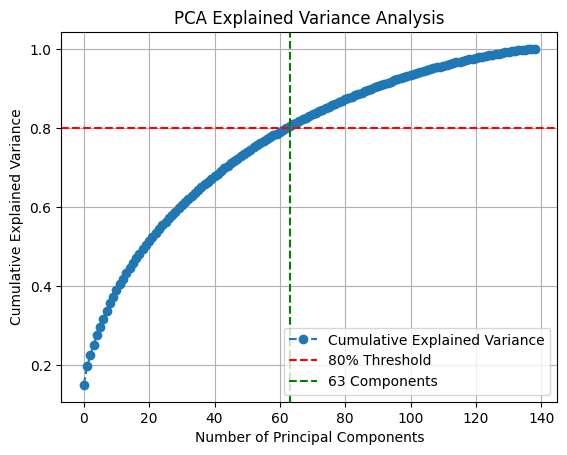

Number of components to explain 80% variance: 63

PCA Analysis for SER Data:


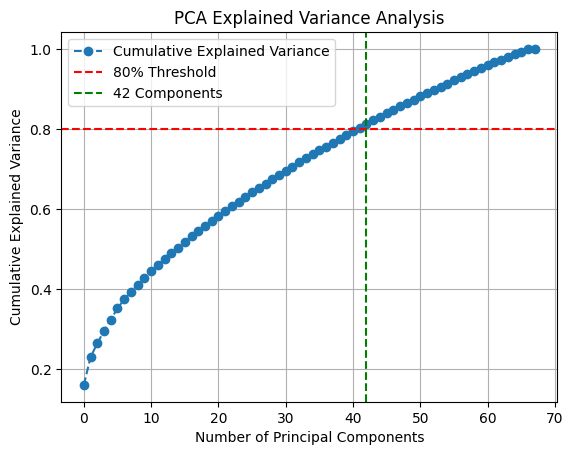

Number of components to explain 80% variance: 42
PCA Analysis for Reactivation Data:


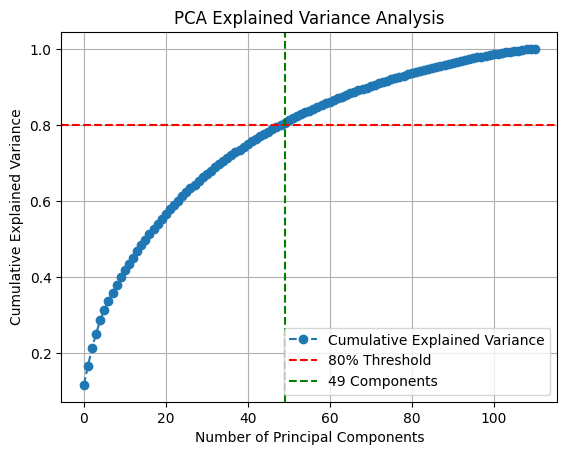

Number of components to explain 80% variance: 49

PCA Analysis for SER Data:


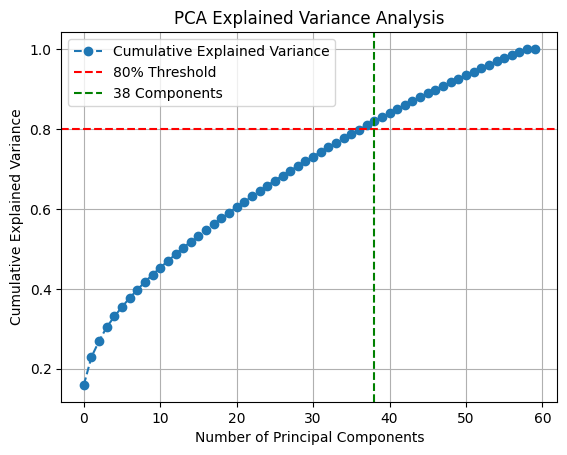

Number of components to explain 80% variance: 38


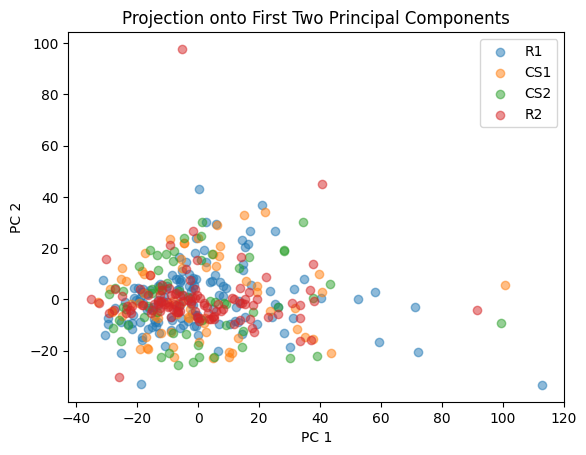

In [20]:
r1_centered, r1_means = center_data(mean_activity_r_1)
cs1_centered, cs1_means = center_data(mean_activity_cs_1)
r2_centered, r2_means = center_data(mean_activity_r_2)
cs2_centered, cs2_means = center_data(mean_activity_cs_2)


print(r1_centered.shape)

print("PCA Analysis for Reactivation Data:")
pca_r_1, num_components_r_1, r1_projected = perform_pca(r1_centered)

# Perform PCA on SER data
print("\nPCA Analysis for SER Data:")
pca_cs_1, num_components_cs_1, cs1_projected = perform_pca(cs1_centered)

print("PCA Analysis for Reactivation Data:")
pca_r_2, num_components_r_2, r2_projected = perform_pca(r2_centered)

# Perform PCA on SER data
print("\nPCA Analysis for SER Data:")
pca_cs_2, num_components_cs_2, cs2_projected = perform_pca(cs2_centered)

plt.scatter(r1_projected[:, 0], r1_projected[:, 1], alpha=0.5, label="R1")
plt.scatter(cs1_projected[:, 0], cs1_projected[:, 1], alpha=0.5, label="CS1")
plt.scatter(cs2_projected[:, 0], cs2_projected[:, 1], alpha=0.5, label="CS2")
plt.scatter(r2_projected[:, 0], r2_projected[:, 1], alpha=0.5, label="R2")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.legend()
plt.title("Projection onto First Two Principal Components")
plt.show()



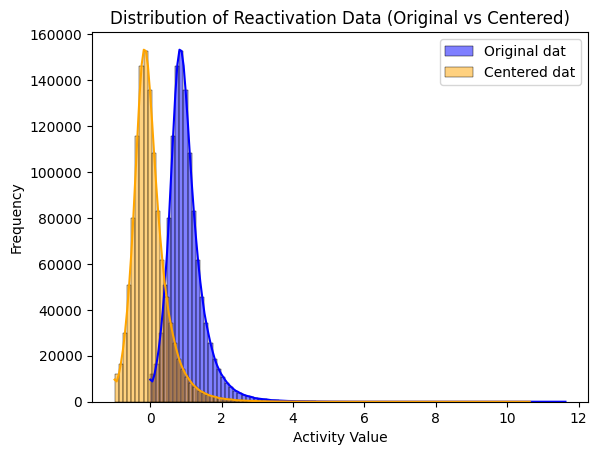

In [23]:
all_dat = np.concatenate([mean_activity_cs_1, mean_activity_cs_2, mean_activity_r_1, mean_activity_r_2])
centered_dat, means_dat = center_data(all_dat)

# Flatten the data for plotting
original_dat_flat = all_dat.flatten()
centered_dat_flat = centered_dat.flatten()

# Plot original vs centered data
sns.histplot(original_dat_flat, bins=100, alpha=0.5, label='Original dat', color='blue', kde=True)
sns.histplot(centered_dat_flat, bins=100, alpha=0.5, label='Centered dat', color='orange', kde=True)
plt.title("Distribution of Reactivation Data (Original vs Centered)")
plt.xlabel("Activity Value")
plt.ylabel("Frequency")
plt.legend()


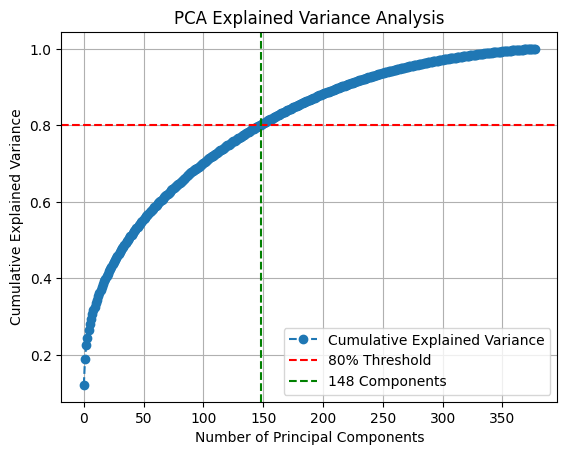

Number of components to explain 80% variance: 148


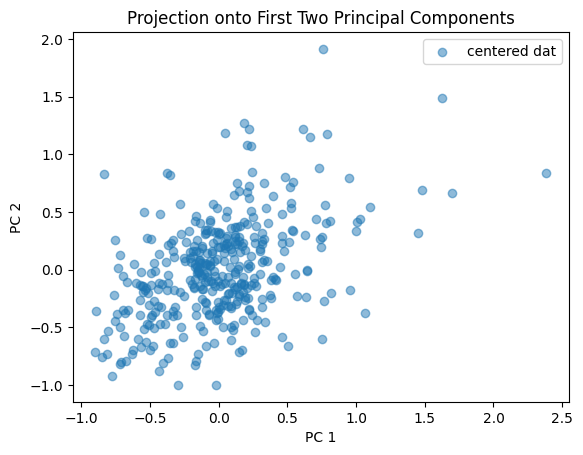

In [24]:
pca_r, num_components_r, reactivation_projected = perform_pca(centered_dat)

plt.scatter(centered_dat[:, 0], centered_dat[:, 1], alpha=0.5, label="centered dat")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.legend()
plt.title("Projection onto First Two Principal Components")
plt.show()
